In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import angorapy as apy

env = apy.make_env("LunarLanderContinuous-v2")
distribution = apy.policies.BetaPolicyDistribution(env)

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
from tensorflow.keras.layers import TimeDistributed
from angorapy.utilities.util import env_extract_dims


def build_my_amazing_model(env, distribution, bs=1, sequence_length=1):
    state_dimensionality, n_actions = env_extract_dims(env)

    inputs = tf.keras.Input(batch_shape=(bs, sequence_length,) + state_dimensionality["proprioception"], name="proprioception")
    masked = tf.keras.layers.Masking(batch_input_shape=(bs, sequence_length,) + (inputs.shape[-1], ))(inputs)

    x = TimeDistributed(tf.keras.layers.Dense(32))(masked)
    x = TimeDistributed(tf.keras.layers.Dense(32))(x)

    x, *_ = tf.keras.layers.LSTM(64,
                       stateful=True,
                       return_sequences=True,
                       return_state=True,
                       batch_size=bs,
                       name="policy_recurrent_layer")(x)

    x_policy = tf.keras.layers.Dense(32)(x)
    x_policy = tf.keras.layers.Dense(32)(x_policy)

    x_value = tf.keras.layers.Dense(32)(x)
    x_value = tf.keras.layers.Dense(32)(x_value)

    out_policy = distribution.build_action_head(n_actions, x_policy.shape[1:], bs)(x_policy)
    out_value = tf.keras.layers.Dense(1)(x_value)

    policy = tf.keras.Model(inputs=inputs, outputs=out_policy, name="my_policy_function")
    value = tf.keras.Model(inputs=inputs, outputs=out_value, name="my_value_function")
    joint = tf.keras.Model(inputs=inputs, outputs=[out_policy, out_value], name="my_joint_networks")

    return policy, value, joint


Detected 0 GPU devices.
Using [StateNormalizationTransformer, RewardNormalizationTransformer] for preprocessing.
An MPI Optimizer with 1 ranks has been created; the following ranks optimize: [0]


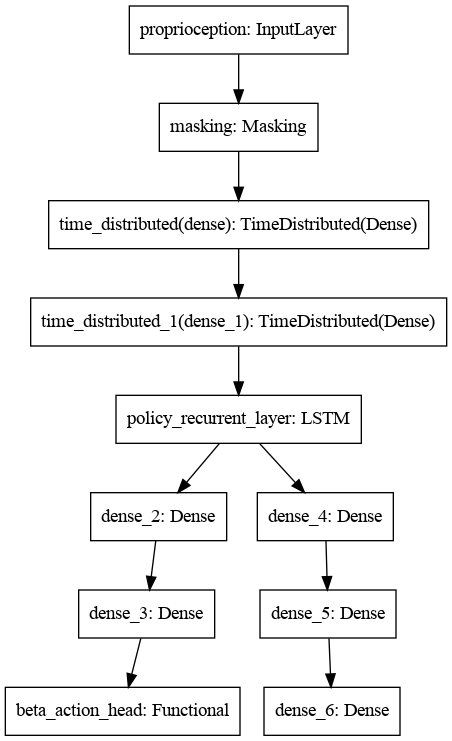

In [3]:
from tensorflow.keras.utils import plot_model

agent = apy.Agent(build_my_amazing_model, env, horizon=2048, workers=12, distribution=distribution)
plot_model(agent.joint)

In [4]:


agent.drill(n=10, epochs=3, batch_size=512)
agent.save_agent_state()



Drill started using 1 processes for 12 workers of which 1 are optimizers. Worker distribution: [12].
IDs over Workers: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
IDs over Optimizers: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

The policy is recurrent and the batch size is interpreted as the number of transitions per policy update. Given the batch size of 512 this results in: 
	32 chunks per update and 48 updates per epoch
	Batch tilings of (1, 32) per process and (1, 32) in total.


Gathering cycle 0...

Gathering experience...: 100%|██████████| 2048/2048 [00:20<00:00, 100.92it/s]


Before Training: r:  -201.83; len:   104.93; n: 214; loss: [  pi  |  v     |  ent ]; eps:     0; lr: 1.00e-03; upd:      0; f:    0.000k; y.exp: 0.000; w: 0.07; times:  ; took s [unknown time left]; mem: 1.59/33|0.0/0.0;


Optimizing...: 100%|██████████| 144/144 [01:28<00:00,  1.62it/s]


Gathering cycle 1...

Gathering experience...: 100%|██████████| 2048/2048 [00:19<00:00, 105.69it/s]


Cycle     1/10: r:  -149.64; len:   111.72; n: 202; loss: [ -0.76|    0.01| -0.15]; eps:   214; lr: 1.00e-03; upd:    144; f:   24.576k; w: 0.06; times: [229.6|0.0|89.1] [72|0|28]; took 332.87s [49.9mins left]; mem: 1.64/33|0.0/0.0;


Optimizing...: 100%|██████████| 144/144 [01:32<00:00,  1.56it/s]


Gathering cycle 2...

Gathering experience...: 100%|██████████| 2048/2048 [00:20<00:00, 101.14it/s]


Cycle     2/10: r:  -129.23; len:   118.49; n: 189; loss: [ -0.13|    0.03| -0.12]; eps:   416; lr: 1.00e-03; upd:    288; f:   49.152k; w: 0.06; times: [243.6|0.0|92.6] [72|0|28]; took 335.65s [44.6mins left]; mem: 1.65/33|0.0/0.0;


Optimizing...: 100%|██████████| 144/144 [01:18<00:00,  1.83it/s]


Gathering cycle 3...

Gathering experience...: 100%|██████████| 2048/2048 [00:19<00:00, 102.46it/s]


Cycle     3/10: r:   -88.93; len:   118.73; n: 191; loss: [ -0.68|    0.01| -0.15]; eps:   605; lr: 1.00e-03; upd:    432; f:   73.728k; w: 0.06; times: [242.8|0.0|78.8] [75|0|24]; took 322.67s [38.5mins left]; mem: 1.67/33|0.0/0.0;


Optimizing...: 100%|██████████| 144/144 [01:26<00:00,  1.66it/s]


Gathering cycle 4...

Gathering experience...:  88%|████████▊ | 1795/2048 [00:18<00:02, 95.78it/s] 


KeyboardInterrupt: 

In [ ]:
evaluation_results = agent.evaluate(10, act_confidently=True)[0]
print(f"Mean performance after training: {np.mean(evaluation_results.episode_rewards)}")